In [58]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from matplotlib import pyplot

In [106]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [122]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series
import numpy as np

In [5]:
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
series = read_csv('datasets/shampoo/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [6]:
# summarize first few rows
print(series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


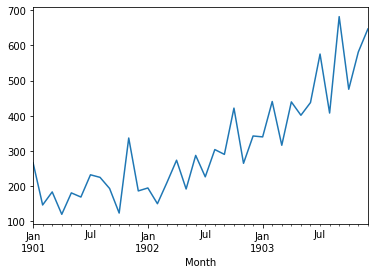

In [7]:
# line plot
series.plot()
pyplot.show()

In [20]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

In [95]:
series

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
1901-11-01    336.5
1901-12-01    185.9
1902-01-01    194.3
1902-02-01    149.5
1902-03-01    210.1
1902-04-01    273.3
1902-05-01    191.4
1902-06-01    287.0
1902-07-01    226.0
1902-08-01    303.6
1902-09-01    289.9
1902-10-01    421.6
1902-11-01    264.5
1902-12-01    342.3
1903-01-01    339.7
1903-02-01    440.4
1903-03-01    315.9
1903-04-01    439.3
1903-05-01    401.3
1903-06-01    437.4
1903-07-01    575.5
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Sales, dtype: float64

In [24]:
# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    
    # observation
    history.append(test[i])

In [28]:
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 136.761


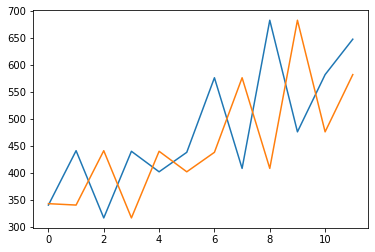

In [29]:
# line plot of observed vs prediced
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

In [30]:
# Before we can fit an LSTM model to the dataset, we must transform the data.

#     1. Transform the time series into a supervised learning problem
#     2. Transform the time series data so that it is stationary.
#     3. Transform the observations to have a specific scale.

In [31]:
###################################################################
# 1. Transform the time series into a supervised learning problem #
###################################################################

In [32]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [35]:
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
series = read_csv('datasets/shampoo/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [36]:
# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


In [37]:
##############################################################
# 2. Transform the time series data so that it is stationary #
##############################################################

# Look only at the differences between each time series, not the actual values

In [48]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [49]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [52]:
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 136.761


In [53]:
print(series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


In [54]:
# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64


In [55]:
# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


In [57]:
##########################################################
# 3. Transform the observations to have a specific scale.#
##########################################################

In [67]:
print(series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


In [121]:
# transform scale
X = series.values
X = X.reshape(len(X), 1)

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
        
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

print(scaled_series.head())
scaled_series = Series(scaled_X[:, 0])


0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64


In [123]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [65]:
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])

print(inverted_series.head())

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


In [75]:
##########################
# LSTM Model Development #
##########################

In [138]:
def fit_lstm(train, batch_size, epochs, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(epochs):
        print('epoch: ', i)
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    
    return model

In [117]:
#################
# LSTM Forecast #
#################

In [147]:
def forecast(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]

In [126]:
# load dataset
series = read_csv('datasets/shampoo/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [128]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [131]:
# transform data to br supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [133]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [134]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [139]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

epoch:  693
epoch:  694
epoch:  695
epoch:  696
epoch:  697
epoch:  698
epoch:  699
epoch:  700
epoch:  701
epoch:  702
epoch:  703
epoch:  704
epoch:  705
epoch:  706
epoch:  707
epoch:  708
epoch:  709
epoch:  710
epoch:  711
epoch:  712
epoch:  713
epoch:  714
epoch:  715
epoch:  716
epoch:  717
epoch:  718
epoch:  719
epoch:  720
epoch:  721
epoch:  722
epoch:  723
epoch:  724
epoch:  725
epoch:  726
epoch:  727
epoch:  728
epoch:  729
epoch:  730
epoch:  731
epoch:  732
epoch:  733
epoch:  734
epoch:  735
epoch:  736
epoch:  737
epoch:  738
epoch:  739
epoch:  740
epoch:  741
epoch:  742
epoch:  743
epoch:  744
epoch:  745
epoch:  746
epoch:  747
epoch:  748
epoch:  749
epoch:  750
epoch:  751
epoch:  752
epoch:  753
epoch:  754
epoch:  755
epoch:  756
epoch:  757
epoch:  758
epoch:  759
epoch:  760
epoch:  761
epoch:  762
epoch:  763
epoch:  764
epoch:  765
epoch:  766
epoch:  767
epoch:  768
epoch:  769
epoch:  770
epoch:  771
epoch:  772
epoch:  773
epoch:  774
epoch:  775
epoc

epoch:  1349
epoch:  1350
epoch:  1351
epoch:  1352
epoch:  1353
epoch:  1354
epoch:  1355
epoch:  1356
epoch:  1357
epoch:  1358
epoch:  1359
epoch:  1360
epoch:  1361
epoch:  1362
epoch:  1363
epoch:  1364
epoch:  1365
epoch:  1366
epoch:  1367
epoch:  1368
epoch:  1369
epoch:  1370
epoch:  1371
epoch:  1372
epoch:  1373
epoch:  1374
epoch:  1375
epoch:  1376
epoch:  1377
epoch:  1378
epoch:  1379
epoch:  1380
epoch:  1381
epoch:  1382
epoch:  1383
epoch:  1384
epoch:  1385
epoch:  1386
epoch:  1387
epoch:  1388
epoch:  1389
epoch:  1390
epoch:  1391
epoch:  1392
epoch:  1393
epoch:  1394
epoch:  1395
epoch:  1396
epoch:  1397
epoch:  1398
epoch:  1399
epoch:  1400
epoch:  1401
epoch:  1402
epoch:  1403
epoch:  1404
epoch:  1405
epoch:  1406
epoch:  1407
epoch:  1408
epoch:  1409
epoch:  1410
epoch:  1411
epoch:  1412
epoch:  1413
epoch:  1414
epoch:  1415
epoch:  1416
epoch:  1417
epoch:  1418
epoch:  1419
epoch:  1420
epoch:  1421
epoch:  1422
epoch:  1423
epoch:  1424
epoch:  1425

epoch:  1981
epoch:  1982
epoch:  1983
epoch:  1984
epoch:  1985
epoch:  1986
epoch:  1987
epoch:  1988
epoch:  1989
epoch:  1990
epoch:  1991
epoch:  1992
epoch:  1993
epoch:  1994
epoch:  1995
epoch:  1996
epoch:  1997
epoch:  1998
epoch:  1999
epoch:  2000
epoch:  2001
epoch:  2002
epoch:  2003
epoch:  2004
epoch:  2005
epoch:  2006
epoch:  2007
epoch:  2008
epoch:  2009
epoch:  2010
epoch:  2011
epoch:  2012
epoch:  2013
epoch:  2014
epoch:  2015
epoch:  2016
epoch:  2017
epoch:  2018
epoch:  2019
epoch:  2020
epoch:  2021
epoch:  2022
epoch:  2023
epoch:  2024
epoch:  2025
epoch:  2026
epoch:  2027
epoch:  2028
epoch:  2029
epoch:  2030
epoch:  2031
epoch:  2032
epoch:  2033
epoch:  2034
epoch:  2035
epoch:  2036
epoch:  2037
epoch:  2038
epoch:  2039
epoch:  2040
epoch:  2041
epoch:  2042
epoch:  2043
epoch:  2044
epoch:  2045
epoch:  2046
epoch:  2047
epoch:  2048
epoch:  2049
epoch:  2050
epoch:  2051
epoch:  2052
epoch:  2053
epoch:  2054
epoch:  2055
epoch:  2056
epoch:  2057

epoch:  2613
epoch:  2614
epoch:  2615
epoch:  2616
epoch:  2617
epoch:  2618
epoch:  2619
epoch:  2620
epoch:  2621
epoch:  2622
epoch:  2623
epoch:  2624
epoch:  2625
epoch:  2626
epoch:  2627
epoch:  2628
epoch:  2629
epoch:  2630
epoch:  2631
epoch:  2632
epoch:  2633
epoch:  2634
epoch:  2635
epoch:  2636
epoch:  2637
epoch:  2638
epoch:  2639
epoch:  2640
epoch:  2641
epoch:  2642
epoch:  2643
epoch:  2644
epoch:  2645
epoch:  2646
epoch:  2647
epoch:  2648
epoch:  2649
epoch:  2650
epoch:  2651
epoch:  2652
epoch:  2653
epoch:  2654
epoch:  2655
epoch:  2656
epoch:  2657
epoch:  2658
epoch:  2659
epoch:  2660
epoch:  2661
epoch:  2662
epoch:  2663
epoch:  2664
epoch:  2665
epoch:  2666
epoch:  2667
epoch:  2668
epoch:  2669
epoch:  2670
epoch:  2671
epoch:  2672
epoch:  2673
epoch:  2674
epoch:  2675
epoch:  2676
epoch:  2677
epoch:  2678
epoch:  2679
epoch:  2680
epoch:  2681
epoch:  2682
epoch:  2683
epoch:  2684
epoch:  2685
epoch:  2686
epoch:  2687
epoch:  2688
epoch:  2689

In [141]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-1.4937968],
       [-1.1891241],
       [-1.5349448],
       [-1.2279118],
       [-1.5677642],
       [-1.2761993],
       [-1.5456376],
       [-1.2905699],
       [-1.3581538],
       [-1.2763447],
       [-2.0086813],
       [-1.0991635],
       [-1.5285735],
       [-1.2465513],
       [-1.5556221],
       [-1.3930682],
       [-1.2586366],
       [-1.6305636],
       [-1.2087895],
       [-1.6233001],
       [-1.2567346],
       [-1.7447522],
       [-1.1241932]], dtype=float32)

In [154]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast(lstm_model, 1, X)
#     yhat = y

    # invert_scaling
    yhat = invert_scale(scaler, X, yhat)
    
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=372.790937, Expected=339.700000
Month=2, Predicted=345.308259, Expected=440.400000
Month=3, Predicted=405.206142, Expected=315.900000
Month=4, Predicted=384.858468, Expected=439.300000
Month=5, Predicted=341.036760, Expected=401.300000
Month=6, Predicted=465.701754, Expected=437.400000
Month=7, Predicted=406.156998, Expected=575.500000
Month=8, Predicted=536.673643, Expected=407.600000
Month=9, Predicted=484.362480, Expected=682.000000
Month=10, Predicted=403.303124, Expected=475.300000
Month=11, Predicted=578.170391, Expected=581.300000
Month=12, Predicted=471.062207, Expected=646.900000


In [155]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 110.310


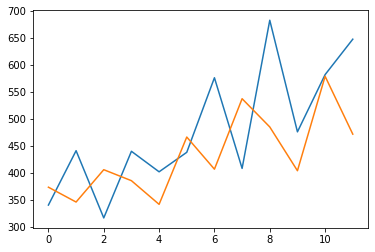

In [156]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

In [157]:
#####################
# Multiple Restarts #
#####################

In [159]:
# repeat experiment
repeats = 10
error_scores = list()

for r in range(repeats):
    print('REP: ', r)
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    
    # walk-forward vlaidation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast(lstm_model, 1, X)
        
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        
        # store forecast
        predictions.append(yhat)
    
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

REP:  0
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
e

epoch:  692
epoch:  693
epoch:  694
epoch:  695
epoch:  696
epoch:  697
epoch:  698
epoch:  699
epoch:  700
epoch:  701
epoch:  702
epoch:  703
epoch:  704
epoch:  705
epoch:  706
epoch:  707
epoch:  708
epoch:  709
epoch:  710
epoch:  711
epoch:  712
epoch:  713
epoch:  714
epoch:  715
epoch:  716
epoch:  717
epoch:  718
epoch:  719
epoch:  720
epoch:  721
epoch:  722
epoch:  723
epoch:  724
epoch:  725
epoch:  726
epoch:  727
epoch:  728
epoch:  729
epoch:  730
epoch:  731
epoch:  732
epoch:  733
epoch:  734
epoch:  735
epoch:  736
epoch:  737
epoch:  738
epoch:  739
epoch:  740
epoch:  741
epoch:  742
epoch:  743
epoch:  744
epoch:  745
epoch:  746
epoch:  747
epoch:  748
epoch:  749
epoch:  750
epoch:  751
epoch:  752
epoch:  753
epoch:  754
epoch:  755
epoch:  756
epoch:  757
epoch:  758
epoch:  759
epoch:  760
epoch:  761
epoch:  762
epoch:  763
epoch:  764
epoch:  765
epoch:  766
epoch:  767
epoch:  768
epoch:  769
epoch:  770
epoch:  771
epoch:  772
epoch:  773
epoch:  774
epoc

epoch:  1348
epoch:  1349
epoch:  1350
epoch:  1351
epoch:  1352
epoch:  1353
epoch:  1354
epoch:  1355
epoch:  1356
epoch:  1357
epoch:  1358
epoch:  1359
epoch:  1360
epoch:  1361
epoch:  1362
epoch:  1363
epoch:  1364
epoch:  1365
epoch:  1366
epoch:  1367
epoch:  1368
epoch:  1369
epoch:  1370
epoch:  1371
epoch:  1372
epoch:  1373
epoch:  1374
epoch:  1375
epoch:  1376
epoch:  1377
epoch:  1378
epoch:  1379
epoch:  1380
epoch:  1381
epoch:  1382
epoch:  1383
epoch:  1384
epoch:  1385
epoch:  1386
epoch:  1387
epoch:  1388
epoch:  1389
epoch:  1390
epoch:  1391
epoch:  1392
epoch:  1393
epoch:  1394
epoch:  1395
epoch:  1396
epoch:  1397
epoch:  1398
epoch:  1399
epoch:  1400
epoch:  1401
epoch:  1402
epoch:  1403
epoch:  1404
epoch:  1405
epoch:  1406
epoch:  1407
epoch:  1408
epoch:  1409
epoch:  1410
epoch:  1411
epoch:  1412
epoch:  1413
epoch:  1414
epoch:  1415
epoch:  1416
epoch:  1417
epoch:  1418
epoch:  1419
epoch:  1420
epoch:  1421
epoch:  1422
epoch:  1423
epoch:  1424

epoch:  1979
epoch:  1980
epoch:  1981
epoch:  1982
epoch:  1983
epoch:  1984
epoch:  1985
epoch:  1986
epoch:  1987
epoch:  1988
epoch:  1989
epoch:  1990
epoch:  1991
epoch:  1992
epoch:  1993
epoch:  1994
epoch:  1995
epoch:  1996
epoch:  1997
epoch:  1998
epoch:  1999
epoch:  2000
epoch:  2001
epoch:  2002
epoch:  2003
epoch:  2004
epoch:  2005
epoch:  2006
epoch:  2007
epoch:  2008
epoch:  2009
epoch:  2010
epoch:  2011
epoch:  2012
epoch:  2013
epoch:  2014
epoch:  2015
epoch:  2016
epoch:  2017
epoch:  2018
epoch:  2019
epoch:  2020
epoch:  2021
epoch:  2022
epoch:  2023
epoch:  2024
epoch:  2025
epoch:  2026
epoch:  2027
epoch:  2028
epoch:  2029
epoch:  2030
epoch:  2031
epoch:  2032
epoch:  2033
epoch:  2034
epoch:  2035
epoch:  2036
epoch:  2037
epoch:  2038
epoch:  2039
epoch:  2040
epoch:  2041
epoch:  2042
epoch:  2043
epoch:  2044
epoch:  2045
epoch:  2046
epoch:  2047
epoch:  2048
epoch:  2049
epoch:  2050
epoch:  2051
epoch:  2052
epoch:  2053
epoch:  2054
epoch:  2055

epoch:  2612
epoch:  2613
epoch:  2614
epoch:  2615
epoch:  2616
epoch:  2617
epoch:  2618
epoch:  2619
epoch:  2620
epoch:  2621
epoch:  2622
epoch:  2623
epoch:  2624
epoch:  2625
epoch:  2626
epoch:  2627
epoch:  2628
epoch:  2629
epoch:  2630
epoch:  2631
epoch:  2632
epoch:  2633
epoch:  2634
epoch:  2635
epoch:  2636
epoch:  2637
epoch:  2638
epoch:  2639
epoch:  2640
epoch:  2641
epoch:  2642
epoch:  2643
epoch:  2644
epoch:  2645
epoch:  2646
epoch:  2647
epoch:  2648
epoch:  2649
epoch:  2650
epoch:  2651
epoch:  2652
epoch:  2653
epoch:  2654
epoch:  2655
epoch:  2656
epoch:  2657
epoch:  2658
epoch:  2659
epoch:  2660
epoch:  2661
epoch:  2662
epoch:  2663
epoch:  2664
epoch:  2665
epoch:  2666
epoch:  2667
epoch:  2668
epoch:  2669
epoch:  2670
epoch:  2671
epoch:  2672
epoch:  2673
epoch:  2674
epoch:  2675
epoch:  2676
epoch:  2677
epoch:  2678
epoch:  2679
epoch:  2680
epoch:  2681
epoch:  2682
epoch:  2683
epoch:  2684
epoch:  2685
epoch:  2686
epoch:  2687
epoch:  2688

epoch:  272
epoch:  273
epoch:  274
epoch:  275
epoch:  276
epoch:  277
epoch:  278
epoch:  279
epoch:  280
epoch:  281
epoch:  282
epoch:  283
epoch:  284
epoch:  285
epoch:  286
epoch:  287
epoch:  288
epoch:  289
epoch:  290
epoch:  291
epoch:  292
epoch:  293
epoch:  294
epoch:  295
epoch:  296
epoch:  297
epoch:  298
epoch:  299
epoch:  300
epoch:  301
epoch:  302
epoch:  303
epoch:  304
epoch:  305
epoch:  306
epoch:  307
epoch:  308
epoch:  309
epoch:  310
epoch:  311
epoch:  312
epoch:  313
epoch:  314
epoch:  315
epoch:  316
epoch:  317
epoch:  318
epoch:  319
epoch:  320
epoch:  321
epoch:  322
epoch:  323
epoch:  324
epoch:  325
epoch:  326
epoch:  327
epoch:  328
epoch:  329
epoch:  330
epoch:  331
epoch:  332
epoch:  333
epoch:  334
epoch:  335
epoch:  336
epoch:  337
epoch:  338
epoch:  339
epoch:  340
epoch:  341
epoch:  342
epoch:  343
epoch:  344
epoch:  345
epoch:  346
epoch:  347
epoch:  348
epoch:  349
epoch:  350
epoch:  351
epoch:  352
epoch:  353
epoch:  354
epoc

epoch:  956
epoch:  957
epoch:  958
epoch:  959
epoch:  960
epoch:  961
epoch:  962
epoch:  963
epoch:  964
epoch:  965
epoch:  966
epoch:  967
epoch:  968
epoch:  969
epoch:  970
epoch:  971
epoch:  972
epoch:  973
epoch:  974
epoch:  975
epoch:  976
epoch:  977
epoch:  978
epoch:  979
epoch:  980
epoch:  981
epoch:  982
epoch:  983
epoch:  984
epoch:  985
epoch:  986
epoch:  987
epoch:  988
epoch:  989
epoch:  990
epoch:  991
epoch:  992
epoch:  993
epoch:  994
epoch:  995
epoch:  996
epoch:  997
epoch:  998
epoch:  999
epoch:  1000
epoch:  1001
epoch:  1002
epoch:  1003
epoch:  1004
epoch:  1005
epoch:  1006
epoch:  1007
epoch:  1008
epoch:  1009
epoch:  1010
epoch:  1011
epoch:  1012
epoch:  1013
epoch:  1014
epoch:  1015
epoch:  1016
epoch:  1017
epoch:  1018
epoch:  1019
epoch:  1020
epoch:  1021
epoch:  1022
epoch:  1023
epoch:  1024
epoch:  1025
epoch:  1026
epoch:  1027
epoch:  1028
epoch:  1029
epoch:  1030
epoch:  1031
epoch:  1032
epoch:  1033
epoch:  1034
epoch:  1035
epoc

epoch:  1592
epoch:  1593
epoch:  1594
epoch:  1595
epoch:  1596
epoch:  1597
epoch:  1598
epoch:  1599
epoch:  1600
epoch:  1601
epoch:  1602
epoch:  1603
epoch:  1604
epoch:  1605
epoch:  1606
epoch:  1607
epoch:  1608
epoch:  1609
epoch:  1610
epoch:  1611
epoch:  1612
epoch:  1613
epoch:  1614
epoch:  1615
epoch:  1616
epoch:  1617
epoch:  1618
epoch:  1619
epoch:  1620
epoch:  1621
epoch:  1622
epoch:  1623
epoch:  1624
epoch:  1625
epoch:  1626
epoch:  1627
epoch:  1628
epoch:  1629
epoch:  1630
epoch:  1631
epoch:  1632
epoch:  1633
epoch:  1634
epoch:  1635
epoch:  1636
epoch:  1637
epoch:  1638
epoch:  1639
epoch:  1640
epoch:  1641
epoch:  1642
epoch:  1643
epoch:  1644
epoch:  1645
epoch:  1646
epoch:  1647
epoch:  1648
epoch:  1649
epoch:  1650
epoch:  1651
epoch:  1652
epoch:  1653
epoch:  1654
epoch:  1655
epoch:  1656
epoch:  1657
epoch:  1658
epoch:  1659
epoch:  1660
epoch:  1661
epoch:  1662
epoch:  1663
epoch:  1664
epoch:  1665
epoch:  1666
epoch:  1667
epoch:  1668

epoch:  2224
epoch:  2225
epoch:  2226
epoch:  2227
epoch:  2228
epoch:  2229
epoch:  2230
epoch:  2231
epoch:  2232
epoch:  2233
epoch:  2234
epoch:  2235
epoch:  2236
epoch:  2237
epoch:  2238
epoch:  2239
epoch:  2240
epoch:  2241
epoch:  2242
epoch:  2243
epoch:  2244
epoch:  2245
epoch:  2246
epoch:  2247
epoch:  2248
epoch:  2249
epoch:  2250
epoch:  2251
epoch:  2252
epoch:  2253
epoch:  2254
epoch:  2255
epoch:  2256
epoch:  2257
epoch:  2258
epoch:  2259
epoch:  2260
epoch:  2261
epoch:  2262
epoch:  2263
epoch:  2264
epoch:  2265
epoch:  2266
epoch:  2267
epoch:  2268
epoch:  2269
epoch:  2270
epoch:  2271
epoch:  2272
epoch:  2273
epoch:  2274
epoch:  2275
epoch:  2276
epoch:  2277
epoch:  2278
epoch:  2279
epoch:  2280
epoch:  2281
epoch:  2282
epoch:  2283
epoch:  2284
epoch:  2285
epoch:  2286
epoch:  2287
epoch:  2288
epoch:  2289
epoch:  2290
epoch:  2291
epoch:  2292
epoch:  2293
epoch:  2294
epoch:  2295
epoch:  2296
epoch:  2297
epoch:  2298
epoch:  2299
epoch:  2300

epoch:  2855
epoch:  2856
epoch:  2857
epoch:  2858
epoch:  2859
epoch:  2860
epoch:  2861
epoch:  2862
epoch:  2863
epoch:  2864
epoch:  2865
epoch:  2866
epoch:  2867
epoch:  2868
epoch:  2869
epoch:  2870
epoch:  2871
epoch:  2872
epoch:  2873
epoch:  2874
epoch:  2875
epoch:  2876
epoch:  2877
epoch:  2878
epoch:  2879
epoch:  2880
epoch:  2881
epoch:  2882
epoch:  2883
epoch:  2884
epoch:  2885
epoch:  2886
epoch:  2887
epoch:  2888
epoch:  2889
epoch:  2890
epoch:  2891
epoch:  2892
epoch:  2893
epoch:  2894
epoch:  2895
epoch:  2896
epoch:  2897
epoch:  2898
epoch:  2899
epoch:  2900
epoch:  2901
epoch:  2902
epoch:  2903
epoch:  2904
epoch:  2905
epoch:  2906
epoch:  2907
epoch:  2908
epoch:  2909
epoch:  2910
epoch:  2911
epoch:  2912
epoch:  2913
epoch:  2914
epoch:  2915
epoch:  2916
epoch:  2917
epoch:  2918
epoch:  2919
epoch:  2920
epoch:  2921
epoch:  2922
epoch:  2923
epoch:  2924
epoch:  2925
epoch:  2926
epoch:  2927
epoch:  2928
epoch:  2929
epoch:  2930
epoch:  2931

epoch:  535
epoch:  536
epoch:  537
epoch:  538
epoch:  539
epoch:  540
epoch:  541
epoch:  542
epoch:  543
epoch:  544
epoch:  545
epoch:  546
epoch:  547
epoch:  548
epoch:  549
epoch:  550
epoch:  551
epoch:  552
epoch:  553
epoch:  554
epoch:  555
epoch:  556
epoch:  557
epoch:  558
epoch:  559
epoch:  560
epoch:  561
epoch:  562
epoch:  563
epoch:  564
epoch:  565
epoch:  566
epoch:  567
epoch:  568
epoch:  569
epoch:  570
epoch:  571
epoch:  572
epoch:  573
epoch:  574
epoch:  575
epoch:  576
epoch:  577
epoch:  578
epoch:  579
epoch:  580
epoch:  581
epoch:  582
epoch:  583
epoch:  584
epoch:  585
epoch:  586
epoch:  587
epoch:  588
epoch:  589
epoch:  590
epoch:  591
epoch:  592
epoch:  593
epoch:  594
epoch:  595
epoch:  596
epoch:  597
epoch:  598
epoch:  599
epoch:  600
epoch:  601
epoch:  602
epoch:  603
epoch:  604
epoch:  605
epoch:  606
epoch:  607
epoch:  608
epoch:  609
epoch:  610
epoch:  611
epoch:  612
epoch:  613
epoch:  614
epoch:  615
epoch:  616
epoch:  617
epoc

epoch:  1202
epoch:  1203
epoch:  1204
epoch:  1205
epoch:  1206
epoch:  1207
epoch:  1208
epoch:  1209
epoch:  1210
epoch:  1211
epoch:  1212
epoch:  1213
epoch:  1214
epoch:  1215
epoch:  1216
epoch:  1217
epoch:  1218
epoch:  1219
epoch:  1220
epoch:  1221
epoch:  1222
epoch:  1223
epoch:  1224
epoch:  1225
epoch:  1226
epoch:  1227
epoch:  1228
epoch:  1229
epoch:  1230
epoch:  1231
epoch:  1232
epoch:  1233
epoch:  1234
epoch:  1235
epoch:  1236
epoch:  1237
epoch:  1238
epoch:  1239
epoch:  1240
epoch:  1241
epoch:  1242
epoch:  1243
epoch:  1244
epoch:  1245
epoch:  1246
epoch:  1247
epoch:  1248
epoch:  1249
epoch:  1250
epoch:  1251
epoch:  1252
epoch:  1253
epoch:  1254
epoch:  1255
epoch:  1256
epoch:  1257
epoch:  1258
epoch:  1259
epoch:  1260
epoch:  1261
epoch:  1262
epoch:  1263
epoch:  1264
epoch:  1265
epoch:  1266
epoch:  1267
epoch:  1268
epoch:  1269
epoch:  1270
epoch:  1271
epoch:  1272
epoch:  1273
epoch:  1274
epoch:  1275
epoch:  1276
epoch:  1277
epoch:  1278

epoch:  1834
epoch:  1835
epoch:  1836
epoch:  1837
epoch:  1838
epoch:  1839
epoch:  1840
epoch:  1841
epoch:  1842
epoch:  1843
epoch:  1844
epoch:  1845
epoch:  1846
epoch:  1847
epoch:  1848
epoch:  1849
epoch:  1850
epoch:  1851
epoch:  1852
epoch:  1853
epoch:  1854
epoch:  1855
epoch:  1856
epoch:  1857
epoch:  1858
epoch:  1859
epoch:  1860
epoch:  1861
epoch:  1862
epoch:  1863
epoch:  1864
epoch:  1865
epoch:  1866
epoch:  1867
epoch:  1868
epoch:  1869
epoch:  1870
epoch:  1871
epoch:  1872
epoch:  1873
epoch:  1874
epoch:  1875
epoch:  1876
epoch:  1877
epoch:  1878
epoch:  1879
epoch:  1880
epoch:  1881
epoch:  1882
epoch:  1883
epoch:  1884
epoch:  1885
epoch:  1886
epoch:  1887
epoch:  1888
epoch:  1889
epoch:  1890
epoch:  1891
epoch:  1892
epoch:  1893
epoch:  1894
epoch:  1895
epoch:  1896
epoch:  1897
epoch:  1898
epoch:  1899
epoch:  1900
epoch:  1901
epoch:  1902
epoch:  1903
epoch:  1904
epoch:  1905
epoch:  1906
epoch:  1907
epoch:  1908
epoch:  1909
epoch:  1910

epoch:  2465
epoch:  2466
epoch:  2467
epoch:  2468
epoch:  2469
epoch:  2470
epoch:  2471
epoch:  2472
epoch:  2473
epoch:  2474
epoch:  2475
epoch:  2476
epoch:  2477
epoch:  2478
epoch:  2479
epoch:  2480
epoch:  2481
epoch:  2482
epoch:  2483
epoch:  2484
epoch:  2485
epoch:  2486
epoch:  2487
epoch:  2488
epoch:  2489
epoch:  2490
epoch:  2491
epoch:  2492
epoch:  2493
epoch:  2494
epoch:  2495
epoch:  2496
epoch:  2497
epoch:  2498
epoch:  2499
epoch:  2500
epoch:  2501
epoch:  2502
epoch:  2503
epoch:  2504
epoch:  2505
epoch:  2506
epoch:  2507
epoch:  2508
epoch:  2509
epoch:  2510
epoch:  2511
epoch:  2512
epoch:  2513
epoch:  2514
epoch:  2515
epoch:  2516
epoch:  2517
epoch:  2518
epoch:  2519
epoch:  2520
epoch:  2521
epoch:  2522
epoch:  2523
epoch:  2524
epoch:  2525
epoch:  2526
epoch:  2527
epoch:  2528
epoch:  2529
epoch:  2530
epoch:  2531
epoch:  2532
epoch:  2533
epoch:  2534
epoch:  2535
epoch:  2536
epoch:  2537
epoch:  2538
epoch:  2539
epoch:  2540
epoch:  2541

epoch:  111
epoch:  112
epoch:  113
epoch:  114
epoch:  115
epoch:  116
epoch:  117
epoch:  118
epoch:  119
epoch:  120
epoch:  121
epoch:  122
epoch:  123
epoch:  124
epoch:  125
epoch:  126
epoch:  127
epoch:  128
epoch:  129
epoch:  130
epoch:  131
epoch:  132
epoch:  133
epoch:  134
epoch:  135
epoch:  136
epoch:  137
epoch:  138
epoch:  139
epoch:  140
epoch:  141
epoch:  142
epoch:  143
epoch:  144
epoch:  145
epoch:  146
epoch:  147
epoch:  148
epoch:  149
epoch:  150
epoch:  151
epoch:  152
epoch:  153
epoch:  154
epoch:  155
epoch:  156
epoch:  157
epoch:  158
epoch:  159
epoch:  160
epoch:  161
epoch:  162
epoch:  163
epoch:  164
epoch:  165
epoch:  166
epoch:  167
epoch:  168
epoch:  169
epoch:  170
epoch:  171
epoch:  172
epoch:  173
epoch:  174
epoch:  175
epoch:  176
epoch:  177
epoch:  178
epoch:  179
epoch:  180
epoch:  181
epoch:  182
epoch:  183
epoch:  184
epoch:  185
epoch:  186
epoch:  187
epoch:  188
epoch:  189
epoch:  190
epoch:  191
epoch:  192
epoch:  193
epoc

epoch:  794
epoch:  795
epoch:  796
epoch:  797
epoch:  798
epoch:  799
epoch:  800
epoch:  801
epoch:  802
epoch:  803
epoch:  804
epoch:  805
epoch:  806
epoch:  807
epoch:  808
epoch:  809
epoch:  810
epoch:  811
epoch:  812
epoch:  813
epoch:  814
epoch:  815
epoch:  816
epoch:  817
epoch:  818
epoch:  819
epoch:  820
epoch:  821
epoch:  822
epoch:  823
epoch:  824
epoch:  825
epoch:  826
epoch:  827
epoch:  828
epoch:  829
epoch:  830
epoch:  831
epoch:  832
epoch:  833
epoch:  834
epoch:  835
epoch:  836
epoch:  837
epoch:  838
epoch:  839
epoch:  840
epoch:  841
epoch:  842
epoch:  843
epoch:  844
epoch:  845
epoch:  846
epoch:  847
epoch:  848
epoch:  849
epoch:  850
epoch:  851
epoch:  852
epoch:  853
epoch:  854
epoch:  855
epoch:  856
epoch:  857
epoch:  858
epoch:  859
epoch:  860
epoch:  861
epoch:  862
epoch:  863
epoch:  864
epoch:  865
epoch:  866
epoch:  867
epoch:  868
epoch:  869
epoch:  870
epoch:  871
epoch:  872
epoch:  873
epoch:  874
epoch:  875
epoch:  876
epoc

epoch:  1443
epoch:  1444
epoch:  1445
epoch:  1446
epoch:  1447
epoch:  1448
epoch:  1449
epoch:  1450
epoch:  1451
epoch:  1452
epoch:  1453
epoch:  1454
epoch:  1455
epoch:  1456
epoch:  1457
epoch:  1458
epoch:  1459
epoch:  1460
epoch:  1461
epoch:  1462
epoch:  1463
epoch:  1464
epoch:  1465
epoch:  1466
epoch:  1467
epoch:  1468
epoch:  1469
epoch:  1470
epoch:  1471
epoch:  1472
epoch:  1473
epoch:  1474
epoch:  1475
epoch:  1476
epoch:  1477
epoch:  1478
epoch:  1479
epoch:  1480
epoch:  1481
epoch:  1482
epoch:  1483
epoch:  1484
epoch:  1485
epoch:  1486
epoch:  1487
epoch:  1488
epoch:  1489
epoch:  1490
epoch:  1491
epoch:  1492
epoch:  1493
epoch:  1494
epoch:  1495
epoch:  1496
epoch:  1497
epoch:  1498
epoch:  1499
epoch:  1500
epoch:  1501
epoch:  1502
epoch:  1503
epoch:  1504
epoch:  1505
epoch:  1506
epoch:  1507
epoch:  1508
epoch:  1509
epoch:  1510
epoch:  1511
epoch:  1512
epoch:  1513
epoch:  1514
epoch:  1515
epoch:  1516
epoch:  1517
epoch:  1518
epoch:  1519

epoch:  2076
epoch:  2077
epoch:  2078
epoch:  2079
epoch:  2080
epoch:  2081
epoch:  2082
epoch:  2083
epoch:  2084
epoch:  2085
epoch:  2086
epoch:  2087
epoch:  2088
epoch:  2089
epoch:  2090
epoch:  2091
epoch:  2092
epoch:  2093
epoch:  2094
epoch:  2095
epoch:  2096
epoch:  2097
epoch:  2098
epoch:  2099
epoch:  2100
epoch:  2101
epoch:  2102
epoch:  2103
epoch:  2104
epoch:  2105
epoch:  2106
epoch:  2107
epoch:  2108
epoch:  2109
epoch:  2110
epoch:  2111
epoch:  2112
epoch:  2113
epoch:  2114
epoch:  2115
epoch:  2116
epoch:  2117
epoch:  2118
epoch:  2119
epoch:  2120
epoch:  2121
epoch:  2122
epoch:  2123
epoch:  2124
epoch:  2125
epoch:  2126
epoch:  2127
epoch:  2128
epoch:  2129
epoch:  2130
epoch:  2131
epoch:  2132
epoch:  2133
epoch:  2134
epoch:  2135
epoch:  2136
epoch:  2137
epoch:  2138
epoch:  2139
epoch:  2140
epoch:  2141
epoch:  2142
epoch:  2143
epoch:  2144
epoch:  2145
epoch:  2146
epoch:  2147
epoch:  2148
epoch:  2149
epoch:  2150
epoch:  2151
epoch:  2152

epoch:  2709
epoch:  2710
epoch:  2711
epoch:  2712
epoch:  2713
epoch:  2714
epoch:  2715
epoch:  2716
epoch:  2717
epoch:  2718
epoch:  2719
epoch:  2720
epoch:  2721
epoch:  2722
epoch:  2723
epoch:  2724
epoch:  2725
epoch:  2726
epoch:  2727
epoch:  2728
epoch:  2729
epoch:  2730
epoch:  2731
epoch:  2732
epoch:  2733
epoch:  2734
epoch:  2735
epoch:  2736
epoch:  2737
epoch:  2738
epoch:  2739
epoch:  2740
epoch:  2741
epoch:  2742
epoch:  2743
epoch:  2744
epoch:  2745
epoch:  2746
epoch:  2747
epoch:  2748
epoch:  2749
epoch:  2750
epoch:  2751
epoch:  2752
epoch:  2753
epoch:  2754
epoch:  2755
epoch:  2756
epoch:  2757
epoch:  2758
epoch:  2759
epoch:  2760
epoch:  2761
epoch:  2762
epoch:  2763
epoch:  2764
epoch:  2765
epoch:  2766
epoch:  2767
epoch:  2768
epoch:  2769
epoch:  2770
epoch:  2771
epoch:  2772
epoch:  2773
epoch:  2774
epoch:  2775
epoch:  2776
epoch:  2777
epoch:  2778
epoch:  2779
epoch:  2780
epoch:  2781
epoch:  2782
epoch:  2783
epoch:  2784
epoch:  2785

epoch:  375
epoch:  376
epoch:  377
epoch:  378
epoch:  379
epoch:  380
epoch:  381
epoch:  382
epoch:  383
epoch:  384
epoch:  385
epoch:  386
epoch:  387
epoch:  388
epoch:  389
epoch:  390
epoch:  391
epoch:  392
epoch:  393
epoch:  394
epoch:  395
epoch:  396
epoch:  397
epoch:  398
epoch:  399
epoch:  400
epoch:  401
epoch:  402
epoch:  403
epoch:  404
epoch:  405
epoch:  406
epoch:  407
epoch:  408
epoch:  409
epoch:  410
epoch:  411
epoch:  412
epoch:  413
epoch:  414
epoch:  415
epoch:  416
epoch:  417
epoch:  418
epoch:  419
epoch:  420
epoch:  421
epoch:  422
epoch:  423
epoch:  424
epoch:  425
epoch:  426
epoch:  427
epoch:  428
epoch:  429
epoch:  430
epoch:  431
epoch:  432
epoch:  433
epoch:  434
epoch:  435
epoch:  436
epoch:  437
epoch:  438
epoch:  439
epoch:  440
epoch:  441
epoch:  442
epoch:  443
epoch:  444
epoch:  445
epoch:  446
epoch:  447
epoch:  448
epoch:  449
epoch:  450
epoch:  451
epoch:  452
epoch:  453
epoch:  454
epoch:  455
epoch:  456
epoch:  457
epoc

epoch:  1054
epoch:  1055
epoch:  1056
epoch:  1057
epoch:  1058
epoch:  1059
epoch:  1060
epoch:  1061
epoch:  1062
epoch:  1063
epoch:  1064
epoch:  1065
epoch:  1066
epoch:  1067
epoch:  1068
epoch:  1069
epoch:  1070
epoch:  1071
epoch:  1072
epoch:  1073
epoch:  1074
epoch:  1075
epoch:  1076
epoch:  1077
epoch:  1078
epoch:  1079
epoch:  1080
epoch:  1081
epoch:  1082
epoch:  1083
epoch:  1084
epoch:  1085
epoch:  1086
epoch:  1087
epoch:  1088
epoch:  1089
epoch:  1090
epoch:  1091
epoch:  1092
epoch:  1093
epoch:  1094
epoch:  1095
epoch:  1096
epoch:  1097
epoch:  1098
epoch:  1099
epoch:  1100
epoch:  1101
epoch:  1102
epoch:  1103
epoch:  1104
epoch:  1105
epoch:  1106
epoch:  1107
epoch:  1108
epoch:  1109
epoch:  1110
epoch:  1111
epoch:  1112
epoch:  1113
epoch:  1114
epoch:  1115
epoch:  1116
epoch:  1117
epoch:  1118
epoch:  1119
epoch:  1120
epoch:  1121
epoch:  1122
epoch:  1123
epoch:  1124
epoch:  1125
epoch:  1126
epoch:  1127
epoch:  1128
epoch:  1129
epoch:  1130

epoch:  1685
epoch:  1686
epoch:  1687
epoch:  1688
epoch:  1689
epoch:  1690
epoch:  1691
epoch:  1692
epoch:  1693
epoch:  1694
epoch:  1695
epoch:  1696
epoch:  1697
epoch:  1698
epoch:  1699
epoch:  1700
epoch:  1701
epoch:  1702
epoch:  1703
epoch:  1704
epoch:  1705
epoch:  1706
epoch:  1707
epoch:  1708
epoch:  1709
epoch:  1710
epoch:  1711
epoch:  1712
epoch:  1713
epoch:  1714
epoch:  1715
epoch:  1716
epoch:  1717
epoch:  1718
epoch:  1719
epoch:  1720
epoch:  1721
epoch:  1722
epoch:  1723
epoch:  1724
epoch:  1725
epoch:  1726
epoch:  1727
epoch:  1728
epoch:  1729
epoch:  1730
epoch:  1731
epoch:  1732
epoch:  1733
epoch:  1734
epoch:  1735
epoch:  1736
epoch:  1737
epoch:  1738
epoch:  1739
epoch:  1740
epoch:  1741
epoch:  1742
epoch:  1743
epoch:  1744
epoch:  1745
epoch:  1746
epoch:  1747
epoch:  1748
epoch:  1749
epoch:  1750
epoch:  1751
epoch:  1752
epoch:  1753
epoch:  1754
epoch:  1755
epoch:  1756
epoch:  1757
epoch:  1758
epoch:  1759
epoch:  1760
epoch:  1761

epoch:  2317
epoch:  2318
epoch:  2319
epoch:  2320
epoch:  2321
epoch:  2322
epoch:  2323
epoch:  2324
epoch:  2325
epoch:  2326
epoch:  2327
epoch:  2328
epoch:  2329
epoch:  2330
epoch:  2331
epoch:  2332
epoch:  2333
epoch:  2334
epoch:  2335
epoch:  2336
epoch:  2337
epoch:  2338
epoch:  2339
epoch:  2340
epoch:  2341
epoch:  2342
epoch:  2343
epoch:  2344
epoch:  2345
epoch:  2346
epoch:  2347
epoch:  2348
epoch:  2349
epoch:  2350
epoch:  2351
epoch:  2352
epoch:  2353
epoch:  2354
epoch:  2355
epoch:  2356
epoch:  2357
epoch:  2358
epoch:  2359
epoch:  2360
epoch:  2361
epoch:  2362
epoch:  2363
epoch:  2364
epoch:  2365
epoch:  2366
epoch:  2367
epoch:  2368
epoch:  2369
epoch:  2370
epoch:  2371
epoch:  2372
epoch:  2373
epoch:  2374
epoch:  2375
epoch:  2376
epoch:  2377
epoch:  2378
epoch:  2379
epoch:  2380
epoch:  2381
epoch:  2382
epoch:  2383
epoch:  2384
epoch:  2385
epoch:  2386
epoch:  2387
epoch:  2388
epoch:  2389
epoch:  2390
epoch:  2391
epoch:  2392
epoch:  2393

epoch:  2948
epoch:  2949
epoch:  2950
epoch:  2951
epoch:  2952
epoch:  2953
epoch:  2954
epoch:  2955
epoch:  2956
epoch:  2957
epoch:  2958
epoch:  2959
epoch:  2960
epoch:  2961
epoch:  2962
epoch:  2963
epoch:  2964
epoch:  2965
epoch:  2966
epoch:  2967
epoch:  2968
epoch:  2969
epoch:  2970
epoch:  2971
epoch:  2972
epoch:  2973
epoch:  2974
epoch:  2975
epoch:  2976
epoch:  2977
epoch:  2978
epoch:  2979
epoch:  2980
epoch:  2981
epoch:  2982
epoch:  2983
epoch:  2984
epoch:  2985
epoch:  2986
epoch:  2987
epoch:  2988
epoch:  2989
epoch:  2990
epoch:  2991
epoch:  2992
epoch:  2993
epoch:  2994
epoch:  2995
epoch:  2996
epoch:  2997
epoch:  2998
epoch:  2999
5) Test RMSE: 87.468
REP:  5
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  

epoch:  635
epoch:  636
epoch:  637
epoch:  638
epoch:  639
epoch:  640
epoch:  641
epoch:  642
epoch:  643
epoch:  644
epoch:  645
epoch:  646
epoch:  647
epoch:  648
epoch:  649
epoch:  650
epoch:  651
epoch:  652
epoch:  653
epoch:  654
epoch:  655
epoch:  656
epoch:  657
epoch:  658
epoch:  659
epoch:  660
epoch:  661
epoch:  662
epoch:  663
epoch:  664
epoch:  665
epoch:  666
epoch:  667
epoch:  668
epoch:  669
epoch:  670
epoch:  671
epoch:  672
epoch:  673
epoch:  674
epoch:  675
epoch:  676
epoch:  677
epoch:  678
epoch:  679
epoch:  680
epoch:  681
epoch:  682
epoch:  683
epoch:  684
epoch:  685
epoch:  686
epoch:  687
epoch:  688
epoch:  689
epoch:  690
epoch:  691
epoch:  692
epoch:  693
epoch:  694
epoch:  695
epoch:  696
epoch:  697
epoch:  698
epoch:  699
epoch:  700
epoch:  701
epoch:  702
epoch:  703
epoch:  704
epoch:  705
epoch:  706
epoch:  707
epoch:  708
epoch:  709
epoch:  710
epoch:  711
epoch:  712
epoch:  713
epoch:  714
epoch:  715
epoch:  716
epoch:  717
epoc

epoch:  1295
epoch:  1296
epoch:  1297
epoch:  1298
epoch:  1299
epoch:  1300
epoch:  1301
epoch:  1302
epoch:  1303
epoch:  1304
epoch:  1305
epoch:  1306
epoch:  1307
epoch:  1308
epoch:  1309
epoch:  1310
epoch:  1311
epoch:  1312
epoch:  1313
epoch:  1314
epoch:  1315
epoch:  1316
epoch:  1317
epoch:  1318
epoch:  1319
epoch:  1320
epoch:  1321
epoch:  1322
epoch:  1323
epoch:  1324
epoch:  1325
epoch:  1326
epoch:  1327
epoch:  1328
epoch:  1329
epoch:  1330
epoch:  1331
epoch:  1332
epoch:  1333
epoch:  1334
epoch:  1335
epoch:  1336
epoch:  1337
epoch:  1338
epoch:  1339
epoch:  1340
epoch:  1341
epoch:  1342
epoch:  1343
epoch:  1344
epoch:  1345
epoch:  1346
epoch:  1347
epoch:  1348
epoch:  1349
epoch:  1350
epoch:  1351
epoch:  1352
epoch:  1353
epoch:  1354
epoch:  1355
epoch:  1356
epoch:  1357
epoch:  1358
epoch:  1359
epoch:  1360
epoch:  1361
epoch:  1362
epoch:  1363
epoch:  1364
epoch:  1365
epoch:  1366
epoch:  1367
epoch:  1368
epoch:  1369
epoch:  1370
epoch:  1371

epoch:  1926
epoch:  1927
epoch:  1928
epoch:  1929
epoch:  1930
epoch:  1931
epoch:  1932
epoch:  1933
epoch:  1934
epoch:  1935
epoch:  1936
epoch:  1937
epoch:  1938
epoch:  1939
epoch:  1940
epoch:  1941
epoch:  1942
epoch:  1943
epoch:  1944
epoch:  1945
epoch:  1946
epoch:  1947
epoch:  1948
epoch:  1949
epoch:  1950
epoch:  1951
epoch:  1952
epoch:  1953
epoch:  1954
epoch:  1955
epoch:  1956
epoch:  1957
epoch:  1958
epoch:  1959
epoch:  1960
epoch:  1961
epoch:  1962
epoch:  1963
epoch:  1964
epoch:  1965
epoch:  1966
epoch:  1967
epoch:  1968
epoch:  1969
epoch:  1970
epoch:  1971
epoch:  1972
epoch:  1973
epoch:  1974
epoch:  1975
epoch:  1976
epoch:  1977
epoch:  1978
epoch:  1979
epoch:  1980
epoch:  1981
epoch:  1982
epoch:  1983
epoch:  1984
epoch:  1985
epoch:  1986
epoch:  1987
epoch:  1988
epoch:  1989
epoch:  1990
epoch:  1991
epoch:  1992
epoch:  1993
epoch:  1994
epoch:  1995
epoch:  1996
epoch:  1997
epoch:  1998
epoch:  1999
epoch:  2000
epoch:  2001
epoch:  2002

epoch:  2557
epoch:  2558
epoch:  2559
epoch:  2560
epoch:  2561
epoch:  2562
epoch:  2563
epoch:  2564
epoch:  2565
epoch:  2566
epoch:  2567
epoch:  2568
epoch:  2569
epoch:  2570
epoch:  2571
epoch:  2572
epoch:  2573
epoch:  2574
epoch:  2575
epoch:  2576
epoch:  2577
epoch:  2578
epoch:  2579
epoch:  2580
epoch:  2581
epoch:  2582
epoch:  2583
epoch:  2584
epoch:  2585
epoch:  2586
epoch:  2587
epoch:  2588
epoch:  2589
epoch:  2590
epoch:  2591
epoch:  2592
epoch:  2593
epoch:  2594
epoch:  2595
epoch:  2596
epoch:  2597
epoch:  2598
epoch:  2599
epoch:  2600
epoch:  2601
epoch:  2602
epoch:  2603
epoch:  2604
epoch:  2605
epoch:  2606
epoch:  2607
epoch:  2608
epoch:  2609
epoch:  2610
epoch:  2611
epoch:  2612
epoch:  2613
epoch:  2614
epoch:  2615
epoch:  2616
epoch:  2617
epoch:  2618
epoch:  2619
epoch:  2620
epoch:  2621
epoch:  2622
epoch:  2623
epoch:  2624
epoch:  2625
epoch:  2626
epoch:  2627
epoch:  2628
epoch:  2629
epoch:  2630
epoch:  2631
epoch:  2632
epoch:  2633

epoch:  212
epoch:  213
epoch:  214
epoch:  215
epoch:  216
epoch:  217
epoch:  218
epoch:  219
epoch:  220
epoch:  221
epoch:  222
epoch:  223
epoch:  224
epoch:  225
epoch:  226
epoch:  227
epoch:  228
epoch:  229
epoch:  230
epoch:  231
epoch:  232
epoch:  233
epoch:  234
epoch:  235
epoch:  236
epoch:  237
epoch:  238
epoch:  239
epoch:  240
epoch:  241
epoch:  242
epoch:  243
epoch:  244
epoch:  245
epoch:  246
epoch:  247
epoch:  248
epoch:  249
epoch:  250
epoch:  251
epoch:  252
epoch:  253
epoch:  254
epoch:  255
epoch:  256
epoch:  257
epoch:  258
epoch:  259
epoch:  260
epoch:  261
epoch:  262
epoch:  263
epoch:  264
epoch:  265
epoch:  266
epoch:  267
epoch:  268
epoch:  269
epoch:  270
epoch:  271
epoch:  272
epoch:  273
epoch:  274
epoch:  275
epoch:  276
epoch:  277
epoch:  278
epoch:  279
epoch:  280
epoch:  281
epoch:  282
epoch:  283
epoch:  284
epoch:  285
epoch:  286
epoch:  287
epoch:  288
epoch:  289
epoch:  290
epoch:  291
epoch:  292
epoch:  293
epoch:  294
epoc

epoch:  895
epoch:  896
epoch:  897
epoch:  898
epoch:  899
epoch:  900
epoch:  901
epoch:  902
epoch:  903
epoch:  904
epoch:  905
epoch:  906
epoch:  907
epoch:  908
epoch:  909
epoch:  910
epoch:  911
epoch:  912
epoch:  913
epoch:  914
epoch:  915
epoch:  916
epoch:  917
epoch:  918
epoch:  919
epoch:  920
epoch:  921
epoch:  922
epoch:  923
epoch:  924
epoch:  925
epoch:  926
epoch:  927
epoch:  928
epoch:  929
epoch:  930
epoch:  931
epoch:  932
epoch:  933
epoch:  934
epoch:  935
epoch:  936
epoch:  937
epoch:  938
epoch:  939
epoch:  940
epoch:  941
epoch:  942
epoch:  943
epoch:  944
epoch:  945
epoch:  946
epoch:  947
epoch:  948
epoch:  949
epoch:  950
epoch:  951
epoch:  952
epoch:  953
epoch:  954
epoch:  955
epoch:  956
epoch:  957
epoch:  958
epoch:  959
epoch:  960
epoch:  961
epoch:  962
epoch:  963
epoch:  964
epoch:  965
epoch:  966
epoch:  967
epoch:  968
epoch:  969
epoch:  970
epoch:  971
epoch:  972
epoch:  973
epoch:  974
epoch:  975
epoch:  976
epoch:  977
epoc

epoch:  1536
epoch:  1537
epoch:  1538
epoch:  1539
epoch:  1540
epoch:  1541
epoch:  1542
epoch:  1543
epoch:  1544
epoch:  1545
epoch:  1546
epoch:  1547
epoch:  1548
epoch:  1549
epoch:  1550
epoch:  1551
epoch:  1552
epoch:  1553
epoch:  1554
epoch:  1555
epoch:  1556
epoch:  1557
epoch:  1558
epoch:  1559
epoch:  1560
epoch:  1561
epoch:  1562
epoch:  1563
epoch:  1564
epoch:  1565
epoch:  1566
epoch:  1567
epoch:  1568
epoch:  1569
epoch:  1570
epoch:  1571
epoch:  1572
epoch:  1573
epoch:  1574
epoch:  1575
epoch:  1576
epoch:  1577
epoch:  1578
epoch:  1579
epoch:  1580
epoch:  1581
epoch:  1582
epoch:  1583
epoch:  1584
epoch:  1585
epoch:  1586
epoch:  1587
epoch:  1588
epoch:  1589
epoch:  1590
epoch:  1591
epoch:  1592
epoch:  1593
epoch:  1594
epoch:  1595
epoch:  1596
epoch:  1597
epoch:  1598
epoch:  1599
epoch:  1600
epoch:  1601
epoch:  1602
epoch:  1603
epoch:  1604
epoch:  1605
epoch:  1606
epoch:  1607
epoch:  1608
epoch:  1609
epoch:  1610
epoch:  1611
epoch:  1612

epoch:  2169
epoch:  2170
epoch:  2171
epoch:  2172
epoch:  2173
epoch:  2174
epoch:  2175
epoch:  2176
epoch:  2177
epoch:  2178
epoch:  2179
epoch:  2180
epoch:  2181
epoch:  2182
epoch:  2183
epoch:  2184
epoch:  2185
epoch:  2186
epoch:  2187
epoch:  2188
epoch:  2189
epoch:  2190
epoch:  2191
epoch:  2192
epoch:  2193
epoch:  2194
epoch:  2195
epoch:  2196
epoch:  2197
epoch:  2198
epoch:  2199
epoch:  2200
epoch:  2201
epoch:  2202
epoch:  2203
epoch:  2204
epoch:  2205
epoch:  2206
epoch:  2207
epoch:  2208
epoch:  2209
epoch:  2210
epoch:  2211
epoch:  2212
epoch:  2213
epoch:  2214
epoch:  2215
epoch:  2216
epoch:  2217
epoch:  2218
epoch:  2219
epoch:  2220
epoch:  2221
epoch:  2222
epoch:  2223
epoch:  2224
epoch:  2225
epoch:  2226
epoch:  2227
epoch:  2228
epoch:  2229
epoch:  2230
epoch:  2231
epoch:  2232
epoch:  2233
epoch:  2234
epoch:  2235
epoch:  2236
epoch:  2237
epoch:  2238
epoch:  2239
epoch:  2240
epoch:  2241
epoch:  2242
epoch:  2243
epoch:  2244
epoch:  2245

epoch:  2800
epoch:  2801
epoch:  2802
epoch:  2803
epoch:  2804
epoch:  2805
epoch:  2806
epoch:  2807
epoch:  2808
epoch:  2809
epoch:  2810
epoch:  2811
epoch:  2812
epoch:  2813
epoch:  2814
epoch:  2815
epoch:  2816
epoch:  2817
epoch:  2818
epoch:  2819
epoch:  2820
epoch:  2821
epoch:  2822
epoch:  2823
epoch:  2824
epoch:  2825
epoch:  2826
epoch:  2827
epoch:  2828
epoch:  2829
epoch:  2830
epoch:  2831
epoch:  2832
epoch:  2833
epoch:  2834
epoch:  2835
epoch:  2836
epoch:  2837
epoch:  2838
epoch:  2839
epoch:  2840
epoch:  2841
epoch:  2842
epoch:  2843
epoch:  2844
epoch:  2845
epoch:  2846
epoch:  2847
epoch:  2848
epoch:  2849
epoch:  2850
epoch:  2851
epoch:  2852
epoch:  2853
epoch:  2854
epoch:  2855
epoch:  2856
epoch:  2857
epoch:  2858
epoch:  2859
epoch:  2860
epoch:  2861
epoch:  2862
epoch:  2863
epoch:  2864
epoch:  2865
epoch:  2866
epoch:  2867
epoch:  2868
epoch:  2869
epoch:  2870
epoch:  2871
epoch:  2872
epoch:  2873
epoch:  2874
epoch:  2875
epoch:  2876

epoch:  473
epoch:  474
epoch:  475
epoch:  476
epoch:  477
epoch:  478
epoch:  479
epoch:  480
epoch:  481
epoch:  482
epoch:  483
epoch:  484
epoch:  485
epoch:  486
epoch:  487
epoch:  488
epoch:  489
epoch:  490
epoch:  491
epoch:  492
epoch:  493
epoch:  494
epoch:  495
epoch:  496
epoch:  497
epoch:  498
epoch:  499
epoch:  500
epoch:  501
epoch:  502
epoch:  503
epoch:  504
epoch:  505
epoch:  506
epoch:  507
epoch:  508
epoch:  509
epoch:  510
epoch:  511
epoch:  512
epoch:  513
epoch:  514
epoch:  515
epoch:  516
epoch:  517
epoch:  518
epoch:  519
epoch:  520
epoch:  521
epoch:  522
epoch:  523
epoch:  524
epoch:  525
epoch:  526
epoch:  527
epoch:  528
epoch:  529
epoch:  530
epoch:  531
epoch:  532
epoch:  533
epoch:  534
epoch:  535
epoch:  536
epoch:  537
epoch:  538
epoch:  539
epoch:  540
epoch:  541
epoch:  542
epoch:  543
epoch:  544
epoch:  545
epoch:  546
epoch:  547
epoch:  548
epoch:  549
epoch:  550
epoch:  551
epoch:  552
epoch:  553
epoch:  554
epoch:  555
epoc

epoch:  1144
epoch:  1145
epoch:  1146
epoch:  1147
epoch:  1148
epoch:  1149
epoch:  1150
epoch:  1151
epoch:  1152
epoch:  1153
epoch:  1154
epoch:  1155
epoch:  1156
epoch:  1157
epoch:  1158
epoch:  1159
epoch:  1160
epoch:  1161
epoch:  1162
epoch:  1163
epoch:  1164
epoch:  1165
epoch:  1166
epoch:  1167
epoch:  1168
epoch:  1169
epoch:  1170
epoch:  1171
epoch:  1172
epoch:  1173
epoch:  1174
epoch:  1175
epoch:  1176
epoch:  1177
epoch:  1178
epoch:  1179
epoch:  1180
epoch:  1181
epoch:  1182
epoch:  1183
epoch:  1184
epoch:  1185
epoch:  1186
epoch:  1187
epoch:  1188
epoch:  1189
epoch:  1190
epoch:  1191
epoch:  1192
epoch:  1193
epoch:  1194
epoch:  1195
epoch:  1196
epoch:  1197
epoch:  1198
epoch:  1199
epoch:  1200
epoch:  1201
epoch:  1202
epoch:  1203
epoch:  1204
epoch:  1205
epoch:  1206
epoch:  1207
epoch:  1208
epoch:  1209
epoch:  1210
epoch:  1211
epoch:  1212
epoch:  1213
epoch:  1214
epoch:  1215
epoch:  1216
epoch:  1217
epoch:  1218
epoch:  1219
epoch:  1220

epoch:  1776
epoch:  1777
epoch:  1778
epoch:  1779
epoch:  1780
epoch:  1781
epoch:  1782
epoch:  1783
epoch:  1784
epoch:  1785
epoch:  1786
epoch:  1787
epoch:  1788
epoch:  1789
epoch:  1790
epoch:  1791
epoch:  1792
epoch:  1793
epoch:  1794
epoch:  1795
epoch:  1796
epoch:  1797
epoch:  1798
epoch:  1799
epoch:  1800
epoch:  1801
epoch:  1802
epoch:  1803
epoch:  1804
epoch:  1805
epoch:  1806
epoch:  1807
epoch:  1808
epoch:  1809
epoch:  1810
epoch:  1811
epoch:  1812
epoch:  1813
epoch:  1814
epoch:  1815
epoch:  1816
epoch:  1817
epoch:  1818
epoch:  1819
epoch:  1820
epoch:  1821
epoch:  1822
epoch:  1823
epoch:  1824
epoch:  1825
epoch:  1826
epoch:  1827
epoch:  1828
epoch:  1829
epoch:  1830
epoch:  1831
epoch:  1832
epoch:  1833
epoch:  1834
epoch:  1835
epoch:  1836
epoch:  1837
epoch:  1838
epoch:  1839
epoch:  1840
epoch:  1841
epoch:  1842
epoch:  1843
epoch:  1844
epoch:  1845
epoch:  1846
epoch:  1847
epoch:  1848
epoch:  1849
epoch:  1850
epoch:  1851
epoch:  1852

epoch:  2409
epoch:  2410
epoch:  2411
epoch:  2412
epoch:  2413
epoch:  2414
epoch:  2415
epoch:  2416
epoch:  2417
epoch:  2418
epoch:  2419
epoch:  2420
epoch:  2421
epoch:  2422
epoch:  2423
epoch:  2424
epoch:  2425
epoch:  2426
epoch:  2427
epoch:  2428
epoch:  2429
epoch:  2430
epoch:  2431
epoch:  2432
epoch:  2433
epoch:  2434
epoch:  2435
epoch:  2436
epoch:  2437
epoch:  2438
epoch:  2439
epoch:  2440
epoch:  2441
epoch:  2442
epoch:  2443
epoch:  2444
epoch:  2445
epoch:  2446
epoch:  2447
epoch:  2448
epoch:  2449
epoch:  2450
epoch:  2451
epoch:  2452
epoch:  2453
epoch:  2454
epoch:  2455
epoch:  2456
epoch:  2457
epoch:  2458
epoch:  2459
epoch:  2460
epoch:  2461
epoch:  2462
epoch:  2463
epoch:  2464
epoch:  2465
epoch:  2466
epoch:  2467
epoch:  2468
epoch:  2469
epoch:  2470
epoch:  2471
epoch:  2472
epoch:  2473
epoch:  2474
epoch:  2475
epoch:  2476
epoch:  2477
epoch:  2478
epoch:  2479
epoch:  2480
epoch:  2481
epoch:  2482
epoch:  2483
epoch:  2484
epoch:  2485

epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  91
epoch:  92
epoch:  93
epoch:  94
epoch:  95
epoch:  96
epoch:  97
epoch:  98
epoch:  99
epoch:  100
epoch:  101
epoch:  102
epoch:  103
epoch:  104
epoch:  105
epoch:  106
epoch:  107
epoch:  108
epoch:  109
epoch:  110
epoch:  111
epoch:  112
epoch:  113
epoch:  114
epoch:  115
epoch:  116
epoch:  117
epoch:  118
epoch:  119
epoch:  120
epoch:  121
epoch:  122
epoch:  123
epoch:  124
epoch:  125
epoch:  126
epoch:  127
epoch:  128
epoch:  129
epoch:  130
epoch:  131
epoch:  132
epoch:  13

epoch:  734
epoch:  735
epoch:  736
epoch:  737
epoch:  738
epoch:  739
epoch:  740
epoch:  741
epoch:  742
epoch:  743
epoch:  744
epoch:  745
epoch:  746
epoch:  747
epoch:  748
epoch:  749
epoch:  750
epoch:  751
epoch:  752
epoch:  753
epoch:  754
epoch:  755
epoch:  756
epoch:  757
epoch:  758
epoch:  759
epoch:  760
epoch:  761
epoch:  762
epoch:  763
epoch:  764
epoch:  765
epoch:  766
epoch:  767
epoch:  768
epoch:  769
epoch:  770
epoch:  771
epoch:  772
epoch:  773
epoch:  774
epoch:  775
epoch:  776
epoch:  777
epoch:  778
epoch:  779
epoch:  780
epoch:  781
epoch:  782
epoch:  783
epoch:  784
epoch:  785
epoch:  786
epoch:  787
epoch:  788
epoch:  789
epoch:  790
epoch:  791
epoch:  792
epoch:  793
epoch:  794
epoch:  795
epoch:  796
epoch:  797
epoch:  798
epoch:  799
epoch:  800
epoch:  801
epoch:  802
epoch:  803
epoch:  804
epoch:  805
epoch:  806
epoch:  807
epoch:  808
epoch:  809
epoch:  810
epoch:  811
epoch:  812
epoch:  813
epoch:  814
epoch:  815
epoch:  816
epoc

epoch:  1385
epoch:  1386
epoch:  1387
epoch:  1388
epoch:  1389
epoch:  1390
epoch:  1391
epoch:  1392
epoch:  1393
epoch:  1394
epoch:  1395
epoch:  1396
epoch:  1397
epoch:  1398
epoch:  1399
epoch:  1400
epoch:  1401
epoch:  1402
epoch:  1403
epoch:  1404
epoch:  1405
epoch:  1406
epoch:  1407
epoch:  1408
epoch:  1409
epoch:  1410
epoch:  1411
epoch:  1412
epoch:  1413
epoch:  1414
epoch:  1415
epoch:  1416
epoch:  1417
epoch:  1418
epoch:  1419
epoch:  1420
epoch:  1421
epoch:  1422
epoch:  1423
epoch:  1424
epoch:  1425
epoch:  1426
epoch:  1427
epoch:  1428
epoch:  1429
epoch:  1430
epoch:  1431
epoch:  1432
epoch:  1433
epoch:  1434
epoch:  1435
epoch:  1436
epoch:  1437
epoch:  1438
epoch:  1439
epoch:  1440
epoch:  1441
epoch:  1442
epoch:  1443
epoch:  1444
epoch:  1445
epoch:  1446
epoch:  1447
epoch:  1448
epoch:  1449
epoch:  1450
epoch:  1451
epoch:  1452
epoch:  1453
epoch:  1454
epoch:  1455
epoch:  1456
epoch:  1457
epoch:  1458
epoch:  1459
epoch:  1460
epoch:  1461

epoch:  2018
epoch:  2019
epoch:  2020
epoch:  2021
epoch:  2022
epoch:  2023
epoch:  2024
epoch:  2025
epoch:  2026
epoch:  2027
epoch:  2028
epoch:  2029
epoch:  2030
epoch:  2031
epoch:  2032
epoch:  2033
epoch:  2034
epoch:  2035
epoch:  2036
epoch:  2037
epoch:  2038
epoch:  2039
epoch:  2040
epoch:  2041
epoch:  2042
epoch:  2043
epoch:  2044
epoch:  2045
epoch:  2046
epoch:  2047
epoch:  2048
epoch:  2049
epoch:  2050
epoch:  2051
epoch:  2052
epoch:  2053
epoch:  2054
epoch:  2055
epoch:  2056
epoch:  2057
epoch:  2058
epoch:  2059
epoch:  2060
epoch:  2061
epoch:  2062
epoch:  2063
epoch:  2064
epoch:  2065
epoch:  2066
epoch:  2067
epoch:  2068
epoch:  2069
epoch:  2070
epoch:  2071
epoch:  2072
epoch:  2073
epoch:  2074
epoch:  2075
epoch:  2076
epoch:  2077
epoch:  2078
epoch:  2079
epoch:  2080
epoch:  2081
epoch:  2082
epoch:  2083
epoch:  2084
epoch:  2085
epoch:  2086
epoch:  2087
epoch:  2088
epoch:  2089
epoch:  2090
epoch:  2091
epoch:  2092
epoch:  2093
epoch:  2094

epoch:  2649
epoch:  2650
epoch:  2651
epoch:  2652
epoch:  2653
epoch:  2654
epoch:  2655
epoch:  2656
epoch:  2657
epoch:  2658
epoch:  2659
epoch:  2660
epoch:  2661
epoch:  2662
epoch:  2663
epoch:  2664
epoch:  2665
epoch:  2666
epoch:  2667
epoch:  2668
epoch:  2669
epoch:  2670
epoch:  2671
epoch:  2672
epoch:  2673
epoch:  2674
epoch:  2675
epoch:  2676
epoch:  2677
epoch:  2678
epoch:  2679
epoch:  2680
epoch:  2681
epoch:  2682
epoch:  2683
epoch:  2684
epoch:  2685
epoch:  2686
epoch:  2687
epoch:  2688
epoch:  2689
epoch:  2690
epoch:  2691
epoch:  2692
epoch:  2693
epoch:  2694
epoch:  2695
epoch:  2696
epoch:  2697
epoch:  2698
epoch:  2699
epoch:  2700
epoch:  2701
epoch:  2702
epoch:  2703
epoch:  2704
epoch:  2705
epoch:  2706
epoch:  2707
epoch:  2708
epoch:  2709
epoch:  2710
epoch:  2711
epoch:  2712
epoch:  2713
epoch:  2714
epoch:  2715
epoch:  2716
epoch:  2717
epoch:  2718
epoch:  2719
epoch:  2720
epoch:  2721
epoch:  2722
epoch:  2723
epoch:  2724
epoch:  2725

epoch:  310
epoch:  311
epoch:  312
epoch:  313
epoch:  314
epoch:  315
epoch:  316
epoch:  317
epoch:  318
epoch:  319
epoch:  320
epoch:  321
epoch:  322
epoch:  323
epoch:  324
epoch:  325
epoch:  326
epoch:  327
epoch:  328
epoch:  329
epoch:  330
epoch:  331
epoch:  332
epoch:  333
epoch:  334
epoch:  335
epoch:  336
epoch:  337
epoch:  338
epoch:  339
epoch:  340
epoch:  341
epoch:  342
epoch:  343
epoch:  344
epoch:  345
epoch:  346
epoch:  347
epoch:  348
epoch:  349
epoch:  350
epoch:  351
epoch:  352
epoch:  353
epoch:  354
epoch:  355
epoch:  356
epoch:  357
epoch:  358
epoch:  359
epoch:  360
epoch:  361
epoch:  362
epoch:  363
epoch:  364
epoch:  365
epoch:  366
epoch:  367
epoch:  368
epoch:  369
epoch:  370
epoch:  371
epoch:  372
epoch:  373
epoch:  374
epoch:  375
epoch:  376
epoch:  377
epoch:  378
epoch:  379
epoch:  380
epoch:  381
epoch:  382
epoch:  383
epoch:  384
epoch:  385
epoch:  386
epoch:  387
epoch:  388
epoch:  389
epoch:  390
epoch:  391
epoch:  392
epoc

epoch:  994
epoch:  995
epoch:  996
epoch:  997
epoch:  998
epoch:  999
epoch:  1000
epoch:  1001
epoch:  1002
epoch:  1003
epoch:  1004
epoch:  1005
epoch:  1006
epoch:  1007
epoch:  1008
epoch:  1009
epoch:  1010
epoch:  1011
epoch:  1012
epoch:  1013
epoch:  1014
epoch:  1015
epoch:  1016
epoch:  1017
epoch:  1018
epoch:  1019
epoch:  1020
epoch:  1021
epoch:  1022
epoch:  1023
epoch:  1024
epoch:  1025
epoch:  1026
epoch:  1027
epoch:  1028
epoch:  1029
epoch:  1030
epoch:  1031
epoch:  1032
epoch:  1033
epoch:  1034
epoch:  1035
epoch:  1036
epoch:  1037
epoch:  1038
epoch:  1039
epoch:  1040
epoch:  1041
epoch:  1042
epoch:  1043
epoch:  1044
epoch:  1045
epoch:  1046
epoch:  1047
epoch:  1048
epoch:  1049
epoch:  1050
epoch:  1051
epoch:  1052
epoch:  1053
epoch:  1054
epoch:  1055
epoch:  1056
epoch:  1057
epoch:  1058
epoch:  1059
epoch:  1060
epoch:  1061
epoch:  1062
epoch:  1063
epoch:  1064
epoch:  1065
epoch:  1066
epoch:  1067
epoch:  1068
epoch:  1069
epoch:  1070
epoch

epoch:  1626
epoch:  1627
epoch:  1628
epoch:  1629
epoch:  1630
epoch:  1631
epoch:  1632
epoch:  1633
epoch:  1634
epoch:  1635
epoch:  1636
epoch:  1637
epoch:  1638
epoch:  1639
epoch:  1640
epoch:  1641
epoch:  1642
epoch:  1643
epoch:  1644
epoch:  1645
epoch:  1646
epoch:  1647
epoch:  1648
epoch:  1649
epoch:  1650
epoch:  1651
epoch:  1652
epoch:  1653
epoch:  1654
epoch:  1655
epoch:  1656
epoch:  1657
epoch:  1658
epoch:  1659
epoch:  1660
epoch:  1661
epoch:  1662
epoch:  1663
epoch:  1664
epoch:  1665
epoch:  1666
epoch:  1667
epoch:  1668
epoch:  1669
epoch:  1670
epoch:  1671
epoch:  1672
epoch:  1673
epoch:  1674
epoch:  1675
epoch:  1676
epoch:  1677
epoch:  1678
epoch:  1679
epoch:  1680
epoch:  1681
epoch:  1682
epoch:  1683
epoch:  1684
epoch:  1685
epoch:  1686
epoch:  1687
epoch:  1688
epoch:  1689
epoch:  1690
epoch:  1691
epoch:  1692
epoch:  1693
epoch:  1694
epoch:  1695
epoch:  1696
epoch:  1697
epoch:  1698
epoch:  1699
epoch:  1700
epoch:  1701
epoch:  1702

epoch:  2258
epoch:  2259
epoch:  2260
epoch:  2261
epoch:  2262
epoch:  2263
epoch:  2264
epoch:  2265
epoch:  2266
epoch:  2267
epoch:  2268
epoch:  2269
epoch:  2270
epoch:  2271
epoch:  2272
epoch:  2273
epoch:  2274
epoch:  2275
epoch:  2276
epoch:  2277
epoch:  2278
epoch:  2279
epoch:  2280
epoch:  2281
epoch:  2282
epoch:  2283
epoch:  2284
epoch:  2285
epoch:  2286
epoch:  2287
epoch:  2288
epoch:  2289
epoch:  2290
epoch:  2291
epoch:  2292
epoch:  2293
epoch:  2294
epoch:  2295
epoch:  2296
epoch:  2297
epoch:  2298
epoch:  2299
epoch:  2300
epoch:  2301
epoch:  2302
epoch:  2303
epoch:  2304
epoch:  2305
epoch:  2306
epoch:  2307
epoch:  2308
epoch:  2309
epoch:  2310
epoch:  2311
epoch:  2312
epoch:  2313
epoch:  2314
epoch:  2315
epoch:  2316
epoch:  2317
epoch:  2318
epoch:  2319
epoch:  2320
epoch:  2321
epoch:  2322
epoch:  2323
epoch:  2324
epoch:  2325
epoch:  2326
epoch:  2327
epoch:  2328
epoch:  2329
epoch:  2330
epoch:  2331
epoch:  2332
epoch:  2333
epoch:  2334

epoch:  2889
epoch:  2890
epoch:  2891
epoch:  2892
epoch:  2893
epoch:  2894
epoch:  2895
epoch:  2896
epoch:  2897
epoch:  2898
epoch:  2899
epoch:  2900
epoch:  2901
epoch:  2902
epoch:  2903
epoch:  2904
epoch:  2905
epoch:  2906
epoch:  2907
epoch:  2908
epoch:  2909
epoch:  2910
epoch:  2911
epoch:  2912
epoch:  2913
epoch:  2914
epoch:  2915
epoch:  2916
epoch:  2917
epoch:  2918
epoch:  2919
epoch:  2920
epoch:  2921
epoch:  2922
epoch:  2923
epoch:  2924
epoch:  2925
epoch:  2926
epoch:  2927
epoch:  2928
epoch:  2929
epoch:  2930
epoch:  2931
epoch:  2932
epoch:  2933
epoch:  2934
epoch:  2935
epoch:  2936
epoch:  2937
epoch:  2938
epoch:  2939
epoch:  2940
epoch:  2941
epoch:  2942
epoch:  2943
epoch:  2944
epoch:  2945
epoch:  2946
epoch:  2947
epoch:  2948
epoch:  2949
epoch:  2950
epoch:  2951
epoch:  2952
epoch:  2953
epoch:  2954
epoch:  2955
epoch:  2956
epoch:  2957
epoch:  2958
epoch:  2959
epoch:  2960
epoch:  2961
epoch:  2962
epoch:  2963
epoch:  2964
epoch:  2965

             rmse
count   10.000000
mean    96.751250
std      9.874441
min     86.227235
25%     90.792225
50%     93.093285
75%    102.484817
max    117.779728


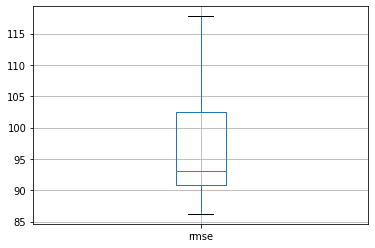

In [160]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

In [ ]:
#              rmse
# count   10.000000
# mean    96.751250
# std      9.874441
# min     86.227235
# 25%     90.792225
# 50%     93.093285
# 75%    102.484817
# max    117.779728